In [1]:
#loading library
library(cluster)
library(randomForest)
library(tmap)
library(sp)
library(sf)
library(terra)

randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug fixes.

Breaking News: tmap 3.x is retiring. Please test v4, e.g. with
remotes::install_github('r-tmap/tmap')

Linking to GEOS 3.10.2, GDAL 3.4.1, PROJ 7.2.1; sf_use_s2() is TRUE

terra 1.7.23



In [2]:
#setting tmap mode to interactive viewing
tmap_mode("view")

tmap mode set to interactive viewing



In [3]:
#Setting Work Directory
setwd("C:/Users/User/Desktop/GwandaLCC/Landsat9images")

In [4]:
# Define file paths for Landsat bands
band2 <- rast("C:/Users/User/Desktop/GwandaLCC/Landsat9images/Landsat92/Band2.TIF")  # Blue
band3 <- rast("C:/Users/User/Desktop/GwandaLCC/Landsat9images/Landsat92/Band3.TIF")  # Green
band4 <- rast("C:/Users/User/Desktop/GwandaLCC/Landsat9images/Landsat92/Band4.TIF")  # Red
band5 <- rast("C:/Users/User/Desktop/GwandaLCC/Landsat9images/Landsat92/Band5.TIF")  # NIR
band6 <- rast("C:/Users/User/Desktop/GwandaLCC/Landsat9images/Landsat92/Band6.TIF")  # SWIR-1
band7 <- rast("C:/Users/User/Desktop/GwandaLCC/Landsat9images/Landsat92/Band7.TIF")  # SIRW-2

In [5]:
stacked_raster <- c(band2, band3, band4, band5, band6, band7)  

In [6]:
class(stacked_raster)

[1] "SpatRaster"
attr(,"package")
[1] "terra"

In [7]:

###ADDING THE SHAPE FILE#################
shapefile <- st_read("Gwanda_Town/Gwanda_Town.shp")

Reading layer `Gwanda_Town' from data source 
  `C:\Users\User\Desktop\GwandaLCC\Landsat9images\Gwanda_Town\Gwanda_Town.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 10 features and 17 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: 28.94965 ymin: -20.95896 xmax: 29.03562 ymax: -20.91023
Geodetic CRS:  WGS 84


In [8]:
# Import the saved stacked raster
stacked_raster <- rast("stacked_raster.tif")

Warning message:
"stacked_raster.tif: No such file or directory (GDAL error 4)"


ERROR: Error: [rast] file does not exist: stacked_raster.tif


In [9]:
# Ensure CRS of shapefile matches raster
shapefile <- st_transform(shapefile, crs(stacked_raster))

In [10]:
# Clip raster with shapefile
clipped_raster <- mask(crop(stacked_raster, vect(shapefile)), vect(shapefile))

In [11]:
# Check number of bands
nlyr(clipped_raster)

[1] 6

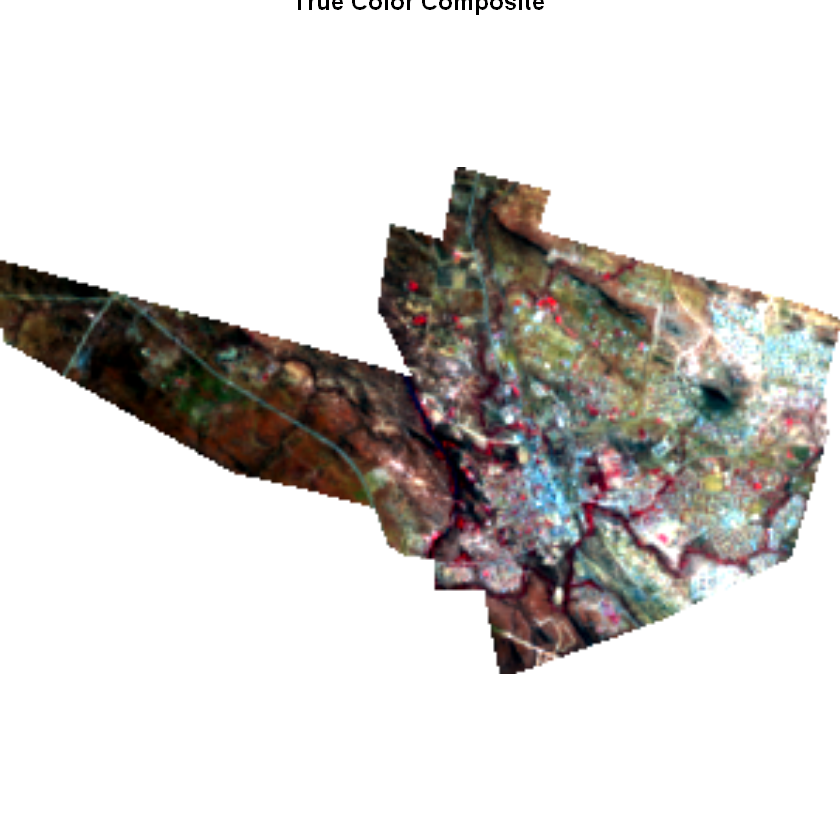

In [12]:
# Visualize the clipped raster as True Color (RGB)
plotRGB(clipped_raster, r = 4, g = 3, b = 2, stretch = "lin", main = "True Color Composite")

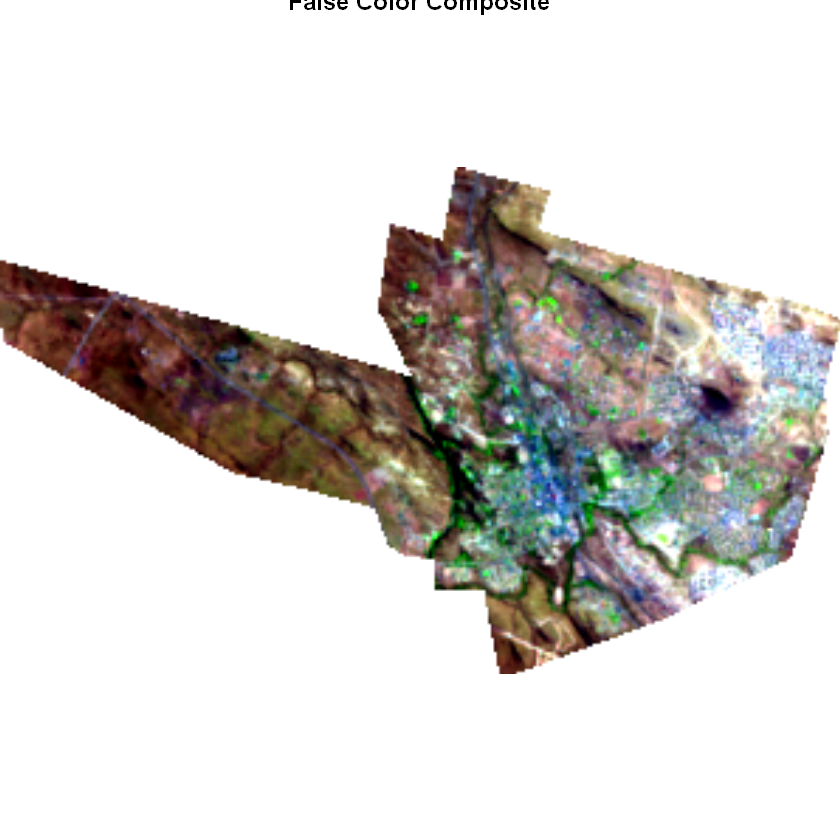

In [13]:
# False Color Composite (NIR = Band 5, Red = Band 4, Green = Band 3)
plotRGB(clipped_raster, r = 5, g = 4, b = 3, stretch = "lin", main = "False Color Composite")

##########################UNSUPERVISED CLASSIFICATION##############

In [14]:
#loading library
library(raster)
library(cluster)
library(randomForest)
library(tmap)

In [15]:
#setting tmap mode to interactive viewing
tmap_mode("view")

tmap mode set to interactive viewing



In [16]:
landsat = brick('C:/Users/User/Desktop/GwandaLCC/Landsat9images/Outputs/clipped_raster.tif')

In [17]:
landsat

class      : RasterBrick 
dimensions : 180, 298, 53640, 6  (nrow, ncol, ncell, nlayers)
resolution : 30, 30  (x, y)
extent     : 702765, 711705, -2318895, -2313495  (xmin, xmax, ymin, ymax)
crs        : +proj=utm +zone=35 +datum=WGS84 +units=m +no_defs 
source     : clipped_raster.tif 
names      : Band2, Band3, Band4, Band5, Band6, Band7 
min values : 10063,  8998,  8621,  8442,  7004,  6192 
max values : 13102, 13673, 17312, 21928, 36928, 31667 


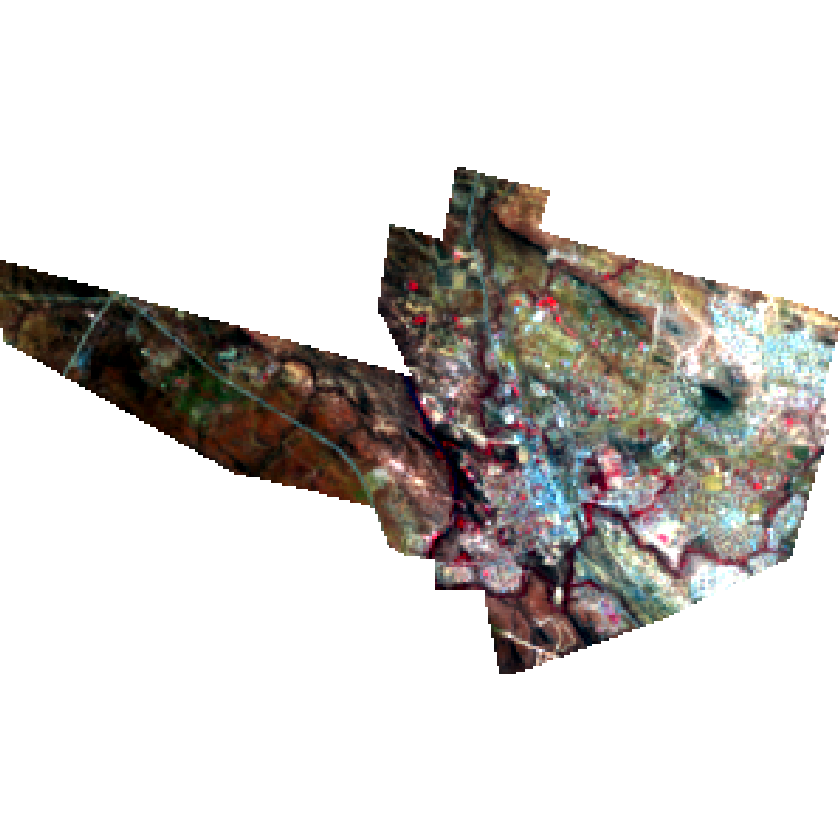

In [18]:
#plotting
plotRGB(landsat,r=4,g=3,b=2, stretch="lin")

In [19]:
#converting raster data in a matrix and removing NA values
v <- getValues(landsat)
i <- which(!is.na(v))
v <-na.omit(v)

In [20]:
#fist method : k means method
E <- kmeans(v, 12, 100, nstart = 10) # 10-Number of classes, number of start - 10, v- omit all missing values
kmeans_raster <- raster(landsat)
kmeans_raster[i] <- E$cluster

Warning message:
"Quick-TRANSfer stage steps exceeded maximum (= 1294400)"
Warning message:
"Quick-TRANSfer stage steps exceeded maximum (= 1294400)"


In [21]:
# Define a color vector for 10 clusters (learn more about setting the color later)

mycolor <- c("#fef65b","#ff0000", "#daa520","#0000ff","#0000ff","#00ff00","#cbbeb5",
             "#c3ff5b", "#ff7373", "#00ff00", "#808080")

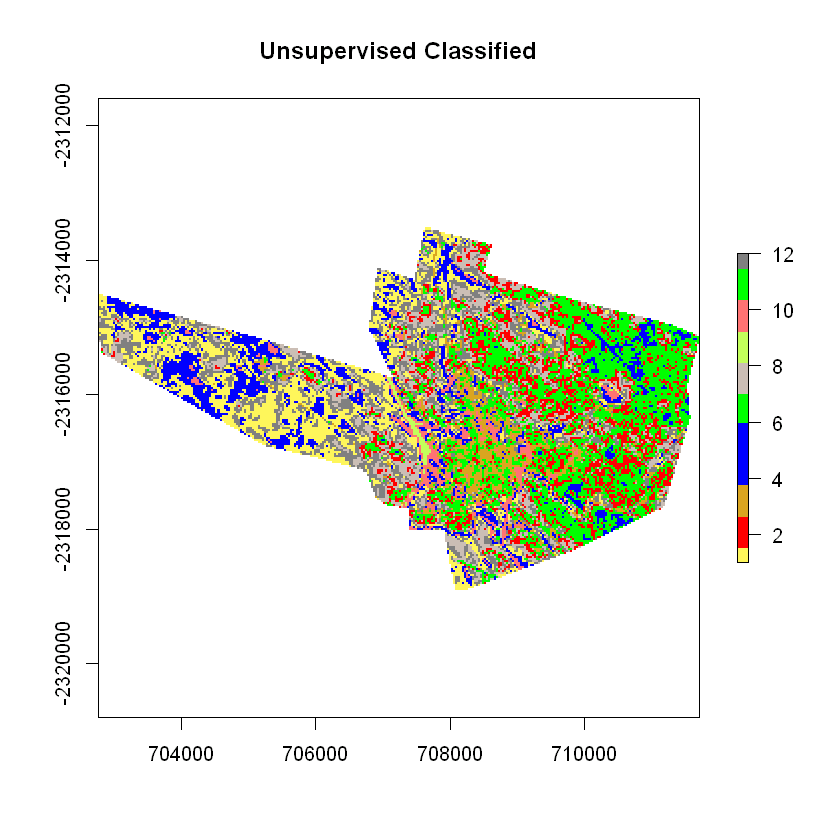

In [22]:
#plotting
plot(kmeans_raster, main="Unsupervised Classified", col=mycolor)
tm_shape(kmeans_raster)+
  tm_raster(palette =  rev(terrain.colors(12)))

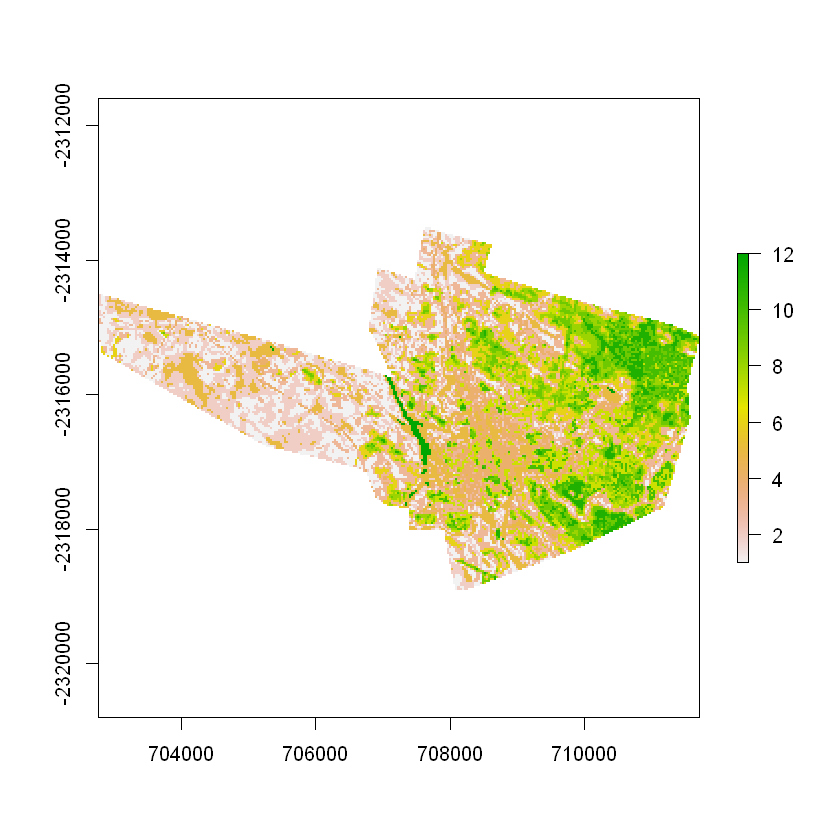

In [23]:
#clara classification
clus <- clara(v,12, samples=500, metric="manhattan", pamLike=T)

clara_raster <- raster(landsat)

clara_raster[i] <- clus$clustering

plot(clara_raster)
tm_shape(clara_raster)+
  tm_raster(palette =  rev(terrain.colors(12)))


In [24]:
#unsupervised random forest classification using kmeans
vx <- v[sample(nrow(v),500),]
rf <- randomForest(vx)
rf_prox <-randomForest(vx, ntree=1000, proximity = TRUE)$proximity

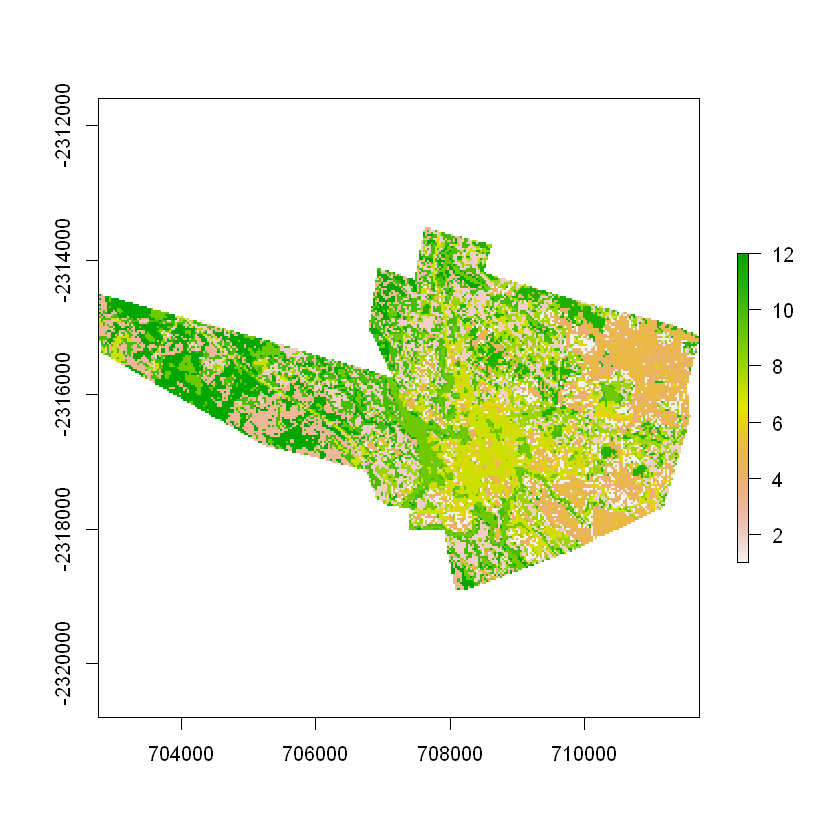

In [25]:
E_rf <- kmeans(rf_prox, 12, iter.max = 100, nstart=10)
rf <- randomForest(vx, as.factor(E_rf$cluster), ntree=500)
rf_raster <- predict(landsat, rf)
plot(rf_raster)
tm_shape(rf_raster)+
  tm_raster(palette =  (terrain.colors(12)))

In [27]:
#FirstMethod k means
E = kmeans(v, 10, 100, nstart=100)
k_meams_raster = raster(landsat)
kmeans_raster[i] = E$cluster

mycolor = c('yellow','blue','orange','red','grey')
tm_shape(kmeans_raster)+
  tm_raster(palette = mycolor)


Warning message:
"Quick-TRANSfer stage steps exceeded maximum (= 1294400)"
Warning message:
"Quick-TRANSfer stage steps exceeded maximum (= 1294400)"
Warning message:
"Quick-TRANSfer stage steps exceeded maximum (= 1294400)"
Warning message:
"Quick-TRANSfer stage steps exceeded maximum (= 1294400)"
Warning message:
"Quick-TRANSfer stage steps exceeded maximum (= 1294400)"
Warning message:
"Quick-TRANSfer stage steps exceeded maximum (= 1294400)"
Warning message:
"Quick-TRANSfer stage steps exceeded maximum (= 1294400)"
Warning message:
"Quick-TRANSfer stage steps exceeded maximum (= 1294400)"
Warning message:
"Quick-TRANSfer stage steps exceeded maximum (= 1294400)"
Warning message:
"Quick-TRANSfer stage steps exceeded maximum (= 1294400)"
Warning message:
"Quick-TRANSfer stage steps exceeded maximum (= 1294400)"
Warning message:
"Quick-TRANSfer stage steps exceeded maximum (= 1294400)"
Warning message:
"Quick-TRANSfer stage steps exceeded maximum (= 1294400)"
Warning message:
"Quick-T

SUPERVISED LAND CLASSIFICATION